In [1]:
import cdsapi

client = cdsapi.Client()

dataset = 'reanalysis-era5-pressure-levels'
request = {
  'product_type': ['reanalysis'],
  'variable': ['geopotential'],
  'year': ['2024'],
  'month': ['03'],
  'day': ['01'],
  'time': ['13:00'],
  'pressure_level': ['1000'],
  'data_format': 'grib',
}
target = 'download.grib'

client.retrieve(dataset, request, target)

2025-08-05 11:08:46,719 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:08:47,565 INFO Request ID is 68d7bf22-6234-45ed-8714-ddf1e4e5a64b
2025-08-05 11:08:47,966 INFO status has been updated to accepted
2025-08-05 11:08:53,874 INFO status has been updated to running
2025-08-05 11:09:03,092 INFO status has been updated to successful


'download.grib'

In [4]:
import cdsapi
import os
import sys
from datetime import datetime
import pandas as pd

def download_era5_data(dataset, request, target, data_format, retries=2):
    """
    Download data from CDS with retries.
    
    Args:
        dataset (str): CDS dataset name.
        request (dict): Request parameters.
        target (str): Output file path.
        data_format (str): 'grib' or 'netcdf'.
        retries (int): Number of retry attempts.
    
    Returns:
        bool: True if successful, False otherwise.
    """
    try:
        client = cdsapi.Client()
        request['format'] = data_format
        for attempt in range(retries):
            try:
                client.retrieve(dataset, request, target)
                if os.path.exists(target):
                    return True
                else:
                    print(f"Attempt {attempt + 1}: Failed to download {target}")
            except Exception as e:
                print(f"Attempt {attempt + 1}: Error downloading {target}: {str(e)}")
        return False
    except Exception as e:
        print(f"Error initializing client for {target}: {str(e)}")
        return False

def convert_bytes_to_readable(size_bytes):
    """
    Convert file size to human-readable format.
    
    Args:
        size_bytes (int): Size in bytes.
    
    Returns:
        str: Size in bytes, KB, or MB.
    """
    if size_bytes < 1024:
        return f"{size_bytes} bytes"
    elif size_bytes < 1024 ** 2:
        return f"{size_bytes / 1024:.2f} KB"
    else:
        return f"{size_bytes / (1024 ** 2):.2f} MB"

def compare_file_sizes(grib_file, netcdf_file):
    """
    Compare sizes of GRIB and NetCDF files.
    
    Args:
        grib_file (str): Path to GRIB file.
        netcdf_file (str): Path to NetCDF file.
    
    Returns:
        dict: Sizes and comparison result.
    """
    result = {}
    try:
        size_grib = os.path.getsize(grib_file) if os.path.exists(grib_file) else 0
        size_netcdf = os.path.getsize(netcdf_file) if os.path.exists(netcdf_file) else 0
        result['size_grib'] = size_grib
        result['size_netcdf'] = size_netcdf
        result['size_grib_readable'] = convert_bytes_to_readable(size_grib)
        result['size_netcdf_readable'] = convert_bytes_to_readable(size_netcdf)
        result['size_diff'] = size_netcdf - size_grib
        result['size_diff_readable'] = convert_bytes_to_readable(abs(size_netcdf - size_grib))
        result['percent_diff'] = ((size_netcdf - size_grib) / size_grib * 100) if size_grib > 0 else float('inf')
        result['comparison'] = (
            "GRIB is smaller" if size_grib < size_netcdf else
            "NetCDF is smaller" if size_netcdf < size_grib else
            "Sizes are equal" if size_grib > 0 and size_netcdf > 0 else
            "Comparison failed: One or both files missing"
        )
    except Exception as e:
        result['comparison'] = f"Error comparing files: {str(e)}"
    return result

def main():
    # Configuration for multiple test cases
    test_cases = [
        {
            'name': 'Small ROI, Single Time',
            'dataset': 'reanalysis-era5-land',
            'variable': ['skin_temperature'],
            'year': ['2024'],
            'month': ['03'],
            'day': ['01'],
            'time': ['12:00'],
            'area': [50, 0, 48, 2],  # Paris: ~2°x2° (~222x170 km)
            'pressure_level': None,
        },
        {
            'name': 'Medium ROI, Daily',
            'dataset': 'reanalysis-era5-land',
            'variable': ['skin_temperature'],
            'year': ['2024'],
            'month': ['03'],
            'day': ['01'],
            'time': [f"{h:02d}:00" for h in range(0, 24, 6)],  # 00:00, 06:00, 12:00, 18:00
            'area': [55, -5, 45, 15],  # Western Europe: ~10°x20° (~1110x1700 km)
            'pressure_level': None,
        },
        {
            'name': 'Large ROI, Monthly',
            'dataset': 'reanalysis-era5-single-levels',
            'variable': ['2m_temperature'],
            'year': ['2024'],
            'month': ['03'],
            'day': [f"{d:02d}" for d in range(1, 32)],  # Full March
            'time': ['12:00'],
            'area': [60, -10, 30, 20],  # Europe: ~30°x30° (~3330x2550 km)
            'pressure_level': None,
        },
        {
            'name': 'Pressure Levels, Single Time',
            'dataset': 'reanalysis-era5-pressure-levels',
            'variable': ['geopotential'],
            'year': ['2024'],
            'month': ['03'],
            'day': ['01'],
            'time': ['12:00'],
            'area': [50, 0, 48, 2],  # Paris
            'pressure_level': ['1000', '850'],
        }
    ]

    results = []
    for test_case in test_cases:
        print(f"\nRunning test case: {test_case['name']}")
        
        # Build request
        request = {
            'product_type': ['reanalysis'],
            'variable': test_case['variable'],
            'year': test_case['year'],
            'month': test_case['month'],
            'day': test_case['day'],
            'time': test_case['time'],
            'area': test_case['area'],
        }
        if test_case['pressure_level']:
            request['pressure_level'] = test_case['pressure_level']
        
        # File names with unique identifiers
        grib_file = f"download_{test_case['name'].replace(' ', '_').lower()}.grib"
        netcdf_file = f"download_{test_case['name'].replace(' ', '_').lower()}.nc"
        
        # Download GRIB
        print(f"Downloading GRIB file to {grib_file}...")
        grib_success = download_era5_data(test_case['dataset'], request, grib_file, 'grib')
        
        # Download NetCDF
        print(f"Downloading NetCDF file to {netcdf_file}...")
        netcdf_success = download_era5_data(test_case['dataset'], request, netcdf_file, 'netcdf')
        
        # Compare sizes
        if grib_success and netcdf_success:
            result = compare_file_sizes(grib_file, netcdf_file)
            result['test_case'] = test_case['name']
            results.append(result)
        else:
            print(f"Test case {test_case['name']} skipped: One or both downloads failed.")
    
    # Display results
    print("\n=== File Size Comparison Results ===")
    df = pd.DataFrame(results)
    if not df.empty:
        print(df[['test_case', 'size_grib_readable', 'size_netcdf_readable', 'size_diff_readable', 'percent_diff', 'comparison']])
    else:
        print("No successful comparisons.")

if __name__ == "__main__":
    main()


Running test case: Small ROI, Single Time


2025-08-05 11:29:28,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:29:29,465 INFO Request ID is 603d77f5-3014-4342-b37b-7ff805ff0d60
2025-08-05 11:29:29,850 INFO status has been updated to accepted
2025-08-05 11:29:35,877 INFO status has been updated to running
2025-08-05 11:29:45,101 INFO status has been updated to successful


2025-08-05 11:29:49,290 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:29:50,080 INFO Request ID is 062ff48d-7cde-4bdb-ada9-e49c7696d462
2025-08-05 11:29:50,454 INFO status has been updated to accepted
2025-08-05 11:29:56,329 INFO status has been updated to running
2025-08-05 11:30:00,076 INFO status has been updated to successful



Running test case: Medium ROI, Daily


2025-08-05 11:30:04,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:30:05,687 INFO Request ID is eaa5bd1d-f2a0-4b54-a0af-3047a17b9ae6
2025-08-05 11:30:06,059 INFO status has been updated to accepted
2025-08-05 11:30:21,227 INFO status has been updated to successful


2025-08-05 11:30:26,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:30:27,226 INFO Request ID is d8814c55-63a2-4cf1-acd5-ff6fdf23e495
2025-08-05 11:30:27,600 INFO status has been updated to accepted
2025-08-05 11:30:33,480 INFO status has been updated to running
2025-08-05 11:30:42,669 INFO status has been updated to successful



Running test case: Large ROI, Monthly


2025-08-05 11:30:48,030 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:30:49,652 INFO Request ID is 52e9e900-ff67-4904-8442-7a2c12beb45e
2025-08-05 11:30:50,025 INFO status has been updated to accepted
2025-08-05 11:30:56,245 INFO status has been updated to running
2025-08-05 11:31:05,412 INFO status has been updated to accepted
2025-08-05 11:31:13,384 INFO status has been updated to successful


2025-08-05 11:31:19,675 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:31:21,092 INFO Request ID is c1a76d32-1bfa-4a57-8c2e-2405b48701b4
2025-08-05 11:31:21,471 INFO status has been updated to accepted
2025-08-05 11:31:27,432 INFO status has been updated to running
2025-08-05 11:31:36,660 INFO status has been updated to successful



Running test case: Pressure Levels, Single Time


2025-08-05 11:31:42,952 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:31:44,172 INFO Request ID is b2a73d5d-9d79-4f7b-b1de-530a5e17821a
2025-08-05 11:31:44,718 INFO status has been updated to accepted
2025-08-05 11:31:59,897 INFO status has been updated to successful


2025-08-05 11:32:04,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:32:04,952 INFO Request ID is 6f359612-5ffe-459d-98de-9a8459e52bfe
2025-08-05 11:32:05,322 INFO status has been updated to accepted
2025-08-05 11:32:15,848 INFO status has been updated to running
2025-08-05 11:32:21,291 INFO status has been updated to successful
                                                                                         


=== File Size Comparison Results ===
                      test_case size_grib_readable size_netcdf_readable  \
0        Small ROI, Single Time          937 bytes             24.65 KB   
1             Medium ROI, Daily          105.86 KB            133.49 KB   
2            Large ROI, Monthly          889.74 KB            727.98 KB   
3  Pressure Levels, Single Time          540 bytes             27.78 KB   

  size_diff_readable  percent_diff         comparison  
0           23.73 KB   2593.383138    GRIB is smaller  
1           27.63 KB     26.100072    GRIB is smaller  
2          161.76 KB    -18.180751  NetCDF is smaller  
3           27.25 KB   5167.962963    GRIB is smaller  


In [9]:
import cdsapi
import os
import xarray as xr
import numpy as np
import pandas as pd

def download_era5_data(dataset, request, target, data_format, retries=2):
    """
    Download data from CDS with retries.
    """
    try:
        client = cdsapi.Client()
        request['format'] = data_format
        for attempt in range(retries):
            try:
                client.retrieve(dataset, request, target)
                if os.path.exists(target):
                    return True
                else:
                    print(f"Attempt {attempt + 1}: Failed to download {target}")
            except Exception as e:
                print(f"Attempt {attempt + 1}: Error downloading {target}: {str(e)}")
        return False
    except Exception as e:
        print(f"Error initializing client for {target}: {str(e)}")
        return False

def convert_bytes_to_readable(size_bytes):
    """
    Convert file size to human-readable format.
    """
    if size_bytes < 1024:
        return f"{size_bytes} bytes"
    elif size_bytes < 1024 ** 2:
        return f"{size_bytes / 1024:.2f} KB"
    else:
        return f"{size_bytes / (1024 ** 2):.2f} MB"

def diagnose_datasets(grib_file, netcdf_file):
    """
    Diagnose differences between GRIB and NetCDF datasets.
    """
    result = {
        'grib_size': 0,
        'netcdf_size': 0,
        'grib_size_readable': 'N/A',
        'netcdf_size_readable': 'N/A',
        'equal': False,
        'differences': []
    }
    
    try:
        # Load datasets
        grib_data = xr.open_dataset(grib_file, engine='cfgrib', decode_timedelta=False)
        netcdf_data = xr.open_dataset(netcdf_file, decode_timedelta=False)
        
        # File sizes
        result['grib_size'] = os.path.getsize(grib_file) if os.path.exists(grib_file) else 0
        result['netcdf_size'] = os.path.getsize(netcdf_file) if os.path.exists(netcdf_file) else 0
        result['grib_size_readable'] = convert_bytes_to_readable(result['grib_size'])
        result['netcdf_size_readable'] = convert_bytes_to_readable(result['netcdf_size'])
        
        # Check equality
        result['equal'] = grib_data.equals(netcdf_data)
        
        # Diagnose differences
        if not result['equal']:
            # Check dimensions
            if set(grib_data.dims) != set(netcdf_data.dims):
                result['differences'].append(f"Dimensions differ: GRIB {grib_data.dims}, NetCDF {netcdf_data.dims}")
            
            # Check variables
            if set(grib_data.variables) != set(netcdf_data.variables):
                result['differences'].append(f"Variables differ: GRIB {list(grib_data.variables)}, NetCDF {list(netcdf_data.variables)}")
            
            # Check data values for common variables
            common_vars = set(grib_data.data_vars) & set(netcdf_data.data_vars)
            for var in common_vars:
                grib_vals = grib_data[var].values
                netcdf_vals = netcdf_data[var].values
                if not np.array_equal(grib_vals, netcdf_vals, equal_nan=True):
                    result['differences'].append(f"Data values differ for {var}")
                    # Compute statistics
                    grib_mean = np.nanmean(grib_vals)
                    netcdf_mean = np.nanmean(netcdf_vals)
                    result['differences'].append(f"{var} mean: GRIB {grib_mean:.2f}, NetCDF {netcdf_mean:.2f}")
            
            # Check time coordinates
            if 'time' in grib_data.coords and 'time' in netcdf_data.coords:
                if not grib_data['time'].equals(netcdf_data['time']):
                    result['differences'].append(f"Time coordinates differ: GRIB {grib_data['time'].values}, NetCDF {netcdf_data['time'].values}")
        
        return result
    except Exception as e:
        result['differences'].append(f"Error loading datasets: {str(e)}")
        return result

def main():
    # Configuration for Large ROI, Monthly test case
    config = {
        'dataset': 'reanalysis-era5-single-levels',
        'variable': ['2m_temperature'],
        'year': ['2024'],
        'month': ['03'],
        'day': [f"{d:02d}" for d in range(1, 32)],
        'time': ['12:00'],
        'area': [60, -10, 30, 20],  # Europe: 30°N–60°N, -10°E–20°E
        'pressure_level': None,
        'grib_file': 'download_large_roi_monthly.grib',
        'netcdf_file': 'download_large_roi_monthly.nc'
    }

    # Redownload files to ensure integrity
    print("Redownloading files to ensure integrity...")
    request = {
        'product_type': ['reanalysis'],
        'variable': config['variable'],
        'year': config['year'],
        'month': config['month'],
        'day': config['day'],
        'time': config['time'],
        'area': config['area'],
    }
    
    grib_success = download_era5_data(config['dataset'], request, config['grib_file'], 'grib')
    netcdf_success = download_era5_data(config['dataset'], request, config['netcdf_file'], 'netcdf')

    if not (grib_success and netcdf_success):
        print("Error: One or both downloads failed.")
        return

    # Diagnose datasets
    result = diagnose_datasets(config['grib_file'], config['netcdf_file'])
    
    # Print results
    print("\n=== File Comparison Results ===")
    print(f"GRIB file size: {result['grib_size_readable']}")
    print(f"NetCDF file size: {result['netcdf_size_readable']}")
    print(f"Size difference: {convert_bytes_to_readable(abs(result['netcdf_size'] - result['grib_size']))}")
    print(f"Percent difference: {result['netcdf_size'] / result['grib_size'] * 100:.2f}% (NetCDF relative to GRIB)")
    print(f"Datasets equal: {result['equal']}")
    if result['differences']:
        print("Differences found:")
        for diff in result['differences']:
            print(f"- {diff}")
    else:
        print("No differences found (datasets are identical).")

if __name__ == "__main__":
    main()

Redownloading files to ensure integrity...


2025-08-05 11:40:45,785 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:40:47,400 INFO Request ID is 9ef33a80-4f51-47e5-910f-2a11b97d6dd6
2025-08-05 11:40:47,814 INFO status has been updated to accepted
2025-08-05 11:41:10,951 INFO status has been updated to successful
2025-08-05 11:41:17,402 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-05 11:41:18,781 INFO Request ID is c20bac90-bb7c-43f3-ba59-d62ce13ab835
2025-08-05 11:41:19,166 INFO status has been updated to accepted
2025-08-05 11:41:28,786 INFO status has been updated to running
2025-08-05 11:41:34,411 INFO status has been updated to successful
                                                                                      


=== File Comparison Results ===
GRIB file size: 889.74 KB
NetCDF file size: 727.98 KB
Size difference: 161.76 KB
Percent difference: 81.82% (NetCDF relative to GRIB)
Datasets equal: False
Differences found:
- Dimensions differ: GRIB FrozenMappingWarningOnValuesAccess({'time': 31, 'latitude': 121, 'longitude': 121}), NetCDF FrozenMappingWarningOnValuesAccess({'valid_time': 31, 'latitude': 121, 'longitude': 121})
- Variables differ: GRIB ['number', 'time', 'step', 'surface', 'latitude', 'longitude', 'valid_time', 't2m'], NetCDF ['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m']


/media/ekai2/data2tb/datmh/Platform/ERA5/venv/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 17MB
Dimensions:     (time: 4, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 32B 2023-01-01 ... 2023-01-01T18:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 32B ...
Data variables:
    t2m         (time, latitude, longitude) float32 17MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-23T10:09 GRIB to CDM+CF via cfgrib-0.9.1...
Frozen({'number': <xarray.Variable ()> Size: 8B
[1 values 

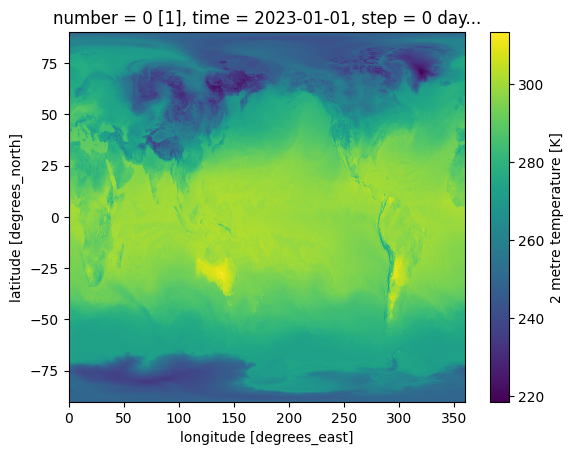

In [3]:
import xarray as xr
import cfgrib

# Load the GRIB file
ds = xr.open_dataset('era5_2m_temperature.grib', engine='cfgrib')

# Explore the dataset
print(ds)  # Shows variables, dimensions, and metadata
print(ds.variables)  # Lists variables like temperature, pressure, etc.

# Access a specific variable (e.g., 2m temperature)
temp = ds['t2m']  # 't2m' is the GRIB short name for 2m temperature
print(temp)

# Plot the data (example for a single time step)
import matplotlib.pyplot as plt
temp.isel(time=0).plot()  # Plot the first time step
plt.show()

In [2]:
%pip install pygrib matplotlib basemap numpy

  Using cached pygrib-2.1.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.6 MB)
  Using cached basemap-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached pyproj-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 3.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


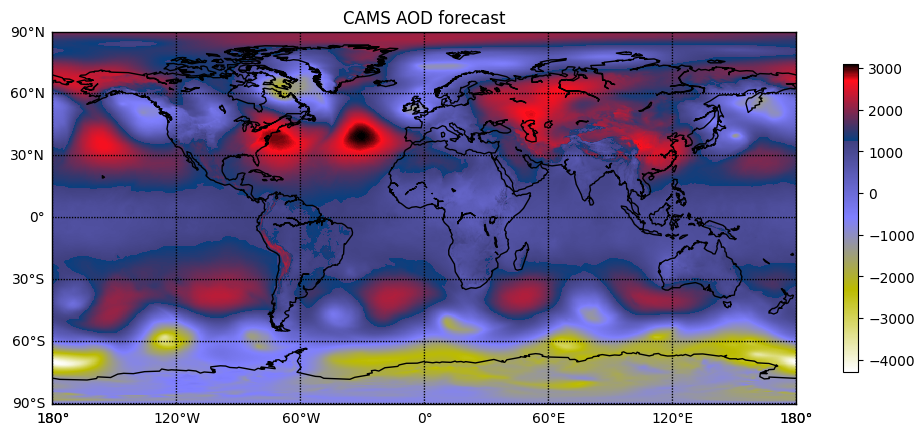

In [4]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import numpy as np
 
plt.figure(figsize=(12,8))
 
grib = 'download.grib' # Set the file name of your input GRIB file
grbs = pygrib.open(grib)
 
grb = grbs.select()[0]
data = grb.values
 
# need to shift data grid longitudes from (0..360) to (-180..180)
lons = np.linspace(float(grb['longitudeOfFirstGridPointInDegrees']), \
float(grb['longitudeOfLastGridPointInDegrees']), int(grb['Ni']) )
lats = np.linspace(float(grb['latitudeOfFirstGridPointInDegrees']), \
float(grb['latitudeOfLastGridPointInDegrees']), int(grb['Nj']) )
data, lons = shiftgrid(180., data, lons, start=False)
grid_lon, grid_lat = np.meshgrid(lons, lats) #regularly spaced 2D grid
 
m = Basemap(projection='cyl', llcrnrlon=-180, \
    urcrnrlon=180.,llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
    resolution='c')
 
x, y = m(grid_lon, grid_lat)
 
cs = m.pcolormesh(x,y,data,shading='nearest',cmap=plt.cm.gist_stern_r)

m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
 
plt.colorbar(cs,orientation='vertical', shrink=0.5)
plt.title('CAMS AOD forecast') # Set the name of the variable to plot
plt.savefig(grib+'.png') # Set the output file name

In [9]:
import cdsapi
import time
import logging
import os
from datetime import datetime, timedelta

# Thiết lập logging
logging.basicConfig(filename='cds_api_limit_test.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Khởi tạo CDS API client
client = cdsapi.Client()

# Định nghĩa khu vực Việt Nam
area = [23.5, 102, 8.5, 110]  # [N, W, S, E]

# Biến ERA5-Daily
variables = ['2m_temperature', 'total_precipitation']

# Dataset chính xác cho ERA5
dataset = 'reanalysis-era5-single-levels'

# Hàm tạo chuỗi ngày dạng "start_date/end_date"
def generate_date_range(start_date, days):
    end_date = start_date + timedelta(days=days - 1)
    return f"{start_date.strftime('%Y-%m-%d')}/{end_date.strftime('%Y-%m-%d')}"

# Hàm gửi yêu cầu CDS API
def send_request(days, start_date_str, output_file):
    start_time = time.time()
    logging.info(f'Bắt đầu yêu cầu: {days} ngày, từ {start_date_str}, file: {output_file}')
    print(f'Gửi yêu cầu: {days} ngày, từ {start_date_str}')

    # Tạo chuỗi ngày dạng "start_date/end_date"
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    date_range = generate_date_range(start_date, days)

    # Tạo yêu cầu
    request = {
        'product_type': 'reanalysis',
        'variable': variables,
        'date': date_range,  # Định dạng "start_date/end_date"
        'time': ['00:00', '06:00', '12:00', '18:00'],  # Lấy dữ liệu hàng giờ
        'area': area,
        'grid': ['0.25', '0.25'],
        'format': 'netcdf'
    }

    try:
        client.retrieve(dataset, request, output_file)
        elapsed_time = time.time() - start_time
        file_size = os.path.getsize(output_file) / (1024 * 1024)  # MB
        logging.info(f'Thành công: {days} ngày, thời gian: {elapsed_time:.2f}s, kích thước: {file_size:.2f}MB')
        print(f'Thành công: {days} ngày, thời gian: {elapsed_time:.2f}s, kích thước: {file_size:.2f}MB')
        return True
    except Exception as e:
        elapsed_time = time.time() - start_time
        logging.error(f'Thất bại: {days} ngày, lỗi: {str(e)}, thời gian: {elapsed_time:.2f}s')
        print(f'Thất bại: {days} ngày, lỗi: {str(e)}')
        return False

# Hàm kiểm tra giới hạn
def test_request_limit():
    start_date = '2023-01-01'
    test_cases = [1, 30, 90, 365, 730, 1825, 3650]
    for days in test_cases:
        output_file = f'era5_daily_vn_{days}_days.nc'
        success = send_request(days, start_date, output_file)
        if not success:
            logging.warning(f'Dừng test tại {days} ngày do yêu cầu thất bại')
            print(f'Dừng test tại {days} ngày')
            break
        time.sleep(10)

if __name__ == '__main__':
    logging.info('Bắt đầu kiểm tra giới hạn CDS API cho ERA5-Daily Việt Nam')
    print('Bắt đầu kiểm tra giới hạn CDS API...')
    test_request_limit()
    logging.info('Hoàn tất kiểm tra')
    print('Hoàn tất kiểm tra')

2025-08-01 10:55:41,914 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Bắt đầu kiểm tra giới hạn CDS API...
Gửi yêu cầu: 1 ngày, từ 2023-01-01


2025-08-01 10:55:43,369 INFO Request ID is 247c65c7-06f0-4568-8cc0-6168db4bcf88
2025-08-01 10:55:43,808 INFO status has been updated to accepted
2025-08-01 10:55:53,890 INFO status has been updated to running
2025-08-01 10:56:00,087 INFO status has been updated to accepted
2025-08-01 10:56:10,499 INFO status has been updated to successful


Thành công: 1 ngày, thời gian: 32.82s, kích thước: 0.07MB
Gửi yêu cầu: 30 ngày, từ 2023-01-01


2025-08-01 10:56:26,863 INFO Request ID is 9b78d9a6-45dc-4e90-86ff-25f2abed002a
2025-08-01 10:56:27,284 INFO status has been updated to accepted
2025-08-01 10:56:33,948 INFO status has been updated to running
2025-08-01 10:57:04,541 INFO status has been updated to successful


Thành công: 30 ngày, thời gian: 47.20s, kích thước: 0.65MB
Gửi yêu cầu: 90 ngày, từ 2023-01-01


2025-08-01 10:57:23,783 INFO Request ID is 4e82e9ff-f4ee-4c60-b62b-a78a29fffd66
2025-08-01 10:57:24,389 INFO status has been updated to accepted
2025-08-01 10:57:31,829 INFO status has been updated to running
2025-08-01 10:57:34,524 INFO status has been updated to accepted
2025-08-01 10:57:38,958 INFO status has been updated to running
2025-08-01 10:58:49,909 INFO status has been updated to successful


Thành công: 90 ngày, thời gian: 104.14s, kích thước: 1.77MB
Gửi yêu cầu: 365 ngày, từ 2023-01-01


2025-08-01 10:59:19,469 INFO Request ID is 34e3d259-cc55-4c63-b414-c02f211b48d3
2025-08-01 10:59:19,927 INFO status has been updated to accepted
2025-08-01 10:59:26,036 INFO status has been updated to running
2025-08-01 11:03:49,340 INFO status has been updated to successful


Thành công: 365 ngày, thời gian: 324.49s, kích thước: 7.84MB
Gửi yêu cầu: 730 ngày, từ 2023-01-01


2025-08-01 11:04:55,076 INFO Request ID is 1006d76a-b12f-4e8e-b62d-26923f984aa0
2025-08-01 11:04:55,523 INFO status has been updated to accepted
2025-08-01 11:05:05,444 INFO status has been updated to running
2025-08-01 11:13:31,161 INFO status has been updated to successful


Thành công: 730 ngày, thời gian: 578.52s, kích thước: 16.95MB
Gửi yêu cầu: 1825 ngày, từ 2023-01-01
Thất bại: 1825 ngày, lỗi: 403 Client Error: Forbidden for url: https://cds.climate.copernicus.eu/api/retrieve/v1/processes/reanalysis-era5-single-levels/execution
cost limits exceeded
Your request is too large, please reduce your selection.
Dừng test tại 1825 ngày
Hoàn tất kiểm tra


In [13]:
import cfgrib
import xarray as xr

# Open the GRIB file as an xarray dataset
ds = cfgrib.open_dataset('download.grib')

# Print the dataset metadata
print(ds)

# Access specific metadata
print(f"Variables: {list(ds.data_vars)}")
print(f"Coordinates: {list(ds.coords)}")
print(f"Attributes: {ds.attrs}")

# Close the dataset
ds.close()

<xarray.Dataset> Size: 4MB
Dimensions:        (latitude: 721, longitude: 1440)
Coordinates:
    number         int64 8B ...
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] 8B ...
Data variables:
    z              (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-01T14:33 GRIB to CDM+CF via cfgrib-0.9.1...
Variables: ['z']
Coordinates: ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', '

/media/ekai2/data2tb/datmh/Platform/ERA5/venv/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
